### Detecting Pneumonia using CNN

In [1]:
!pip install -q kaggle
#!pip install tensorflow==2.0.0

### Import Relevant Libraries and Modules

In [2]:
# Import relevant libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import re

In [77]:
try:
    tcr = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tcr.master())
    tf.config.experimental_connect_to_cluster(tcr)
    tf.tpu.experimental.initialize_tpu_system(tcr)
    stratcr = tf.distribute.experimental.TPUStrategy(tcr)
except:
    stratcr = tf.distribute.get_strategy()

### Get Dataset from Kaggle

In [7]:
# Move file to ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#Change permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#kaggle.json file
from google.colab import files
files.upload()

In [8]:
# Download dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:13<00:00, 222MB/s]
100% 2.29G/2.29G [00:13<00:00, 182MB/s]


In [9]:
# Create input and output directories
!mkdir -p pneumonia/input
!mkdir -p pneumonia/output

In [10]:
# Unzip dataset
!unzip -d pneumonia/input chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: pneumonia/input/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: pneumonia/input/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: pneumonia/input/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: pneumonia/input/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: pneumonia/input/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: pneumonia/input/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: pneumonia/input/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: pneumonia/input/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: pneumonia/input/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: pneumonia/input/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: pneumonia/input/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: pneumonia/input/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: pneumonia/input/chest_xray/train/NO

In [11]:
import os
for dirname, _, filenames in os.walk('pneumonia/input/chest_xray/'):
        print(os.path.join(dirname))

pneumonia/input/chest_xray/
pneumonia/input/chest_xray/__MACOSX
pneumonia/input/chest_xray/__MACOSX/chest_xray
pneumonia/input/chest_xray/__MACOSX/chest_xray/train
pneumonia/input/chest_xray/__MACOSX/chest_xray/train/PNEUMONIA
pneumonia/input/chest_xray/__MACOSX/chest_xray/train/NORMAL
pneumonia/input/chest_xray/__MACOSX/chest_xray/val
pneumonia/input/chest_xray/__MACOSX/chest_xray/val/PNEUMONIA
pneumonia/input/chest_xray/__MACOSX/chest_xray/val/NORMAL
pneumonia/input/chest_xray/__MACOSX/chest_xray/test
pneumonia/input/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA
pneumonia/input/chest_xray/__MACOSX/chest_xray/test/NORMAL
pneumonia/input/chest_xray/train
pneumonia/input/chest_xray/train/PNEUMONIA
pneumonia/input/chest_xray/train/NORMAL
pneumonia/input/chest_xray/val
pneumonia/input/chest_xray/val/PNEUMONIA
pneumonia/input/chest_xray/val/NORMAL
pneumonia/input/chest_xray/test
pneumonia/input/chest_xray/test/PNEUMONIA
pneumonia/input/chest_xray/test/NORMAL
pneumonia/input/chest_xray/ches

In [16]:
collect= (tf.io.gfile.glob(str('pneumonia/input/chest_xray/train/*/*')))
collect.extend(tf.io.gfile.glob(str('pneumonia/input/chest_xray/val/*/*')))
collect_train, collect_val = train_test_split(collect, test_size=0.2)

In [29]:
# Visualize number of images belonging to each category
normal=0
for each in collect_train:
        if re.search("NORMAL", each):
                     normal+=1
print("Number of images in the dataset categorized as normal : " + str(normal))
pneumonia=0
for each in collect_train:
        if re.search("PNEUMONIA", each):
                     pneumonia+=1
print("Number of images in the dataset categorized as pneumonia : " + str(pneumonia))

Number of images in the dataset categorized as normal : 1076
Number of images in the dataset categorized as pneumonia : 3109


In [32]:
collect_train_complete = tf.data.Dataset.from_tensor_slices(collect_train)
collect_val_complete = tf.data.Dataset.from_tensor_slices(collect_val)

In [37]:
#Print the number of images in each set-training and validation
print("Number of training images: " + str(tf.data.experimental.cardinality(collect_train_complete).numpy()))
#nb_val = tf.data.experimental.cardinality(collect_val_complete).numpy()
print("Number of validation images: " + str(tf.data.experimental.cardinality(collect_val_complete).numpy()))

Number of training images: 4185
Number of validation images: 1047


In [39]:
categories = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str('pneumonia/input/chest_xray/chest_xray/train/*'))])
categories

array(['.DS_Store', 'PNEUMONIA', 'NORMAL'], dtype='<U9')

In [40]:
def LabelExtract(send_file):
    components = tf.strings.split(send_file, os.path.sep)
    return components[(len(components)-2)] == "PNEUMONIA"

In [41]:
def ImageProcess(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  return tf.image.resize(image, [150, 150])

In [42]:
def location(send_file):
    label = LabelExtract(send_file)
    image = tf.io.read_file(send_file)
    image = ImageProcess(image)
    return image, label

In [43]:
data_train = collect_train_complete.map(location, num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_val = collect_val_complete.map(location, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [45]:
collect_test_complete = tf.data.Dataset.list_files(str('pneumonia/input/chest_xray/chest_xray/test/*/*'))
nb_test = tf.data.experimental.cardinality(collect_test_complete).numpy()
data_test = collect_test_complete.map(location, num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_test = data_test.batch(16 * stratcr.num_replicas_in_sync)

624

In [48]:
def PreTrain(data, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            data = data.cache(cache)
        else:
            data = data.cache()

    data = data.shuffle(buffer_size=shuffle_buffer_size)

    data = data.repeat()
    #print(16 * stratcr.num_replicas_in_sync)
    data = data.batch(16 * stratcr.num_replicas_in_sync)
    data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return data

In [49]:
data_train = PreTrain(data_train)
data_val = PreTrain(data_val)

next_image, next_label = next(iter(data_train))

### Building CNN Model

In [52]:
def convolution(dim):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(dim, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(dim, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [53]:
def dense(nb, rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(nb, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate)
    ])
    
    return block

In [54]:
def construct_cnn():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(150, 150, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        convolution(32),
        convolution(64),
        
        convolution(128),
        tf.keras.layers.Dropout(0.2),
        
        convolution(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense(512, 0.7),
        dense(128, 0.5),
        dense(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## AUGMENT DATA

In [55]:
skew = np.log([pneumonia/normal])
skew

array([1.06105067])

In [63]:
normal_wt = (1 / normal)*(tf.data.experimental.cardinality(collect_train_complete).numpy())/2.0 
pneumonia_wt = (1 / pneumonia)*(tf.data.experimental.cardinality(collect_train_complete).numpy())/2.0

class_weight = {0: normal_wt, 1: pneumonia_wt}

print('Weight for class 0: {:.2f}'.format(normal_wt))
print('Weight for class 1: {:.2f}'.format(pneumonia_wt))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [61]:
with stratcr.scope():
    model = construct_cnn()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    )

In [62]:
history = model.fit(
    data_train,
    steps_per_epoch=tf.data.experimental.cardinality(collect_train_complete).numpy() // (16 * stratcr.num_replicas_in_sync),
    epochs=10,
    validation_data=data_val,
    validation_steps=tf.data.experimental.cardinality(collect_val_complete).numpy() // (16 * stratcr.num_replicas_in_sync),
    class_weight=class_weight,
) 

Epoch 1/10
261/261 [==============================] - 308s 1s/step - loss: 0.4025 - accuracy: 0.8218 - precision: 0.9555 - recall: 0.7971 - val_loss: 0.7451 - val_accuracy: 0.7404 - val_precision: 0.7404 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 214s 820ms/step - loss: 0.2578 - accuracy: 0.9004 - precision: 0.9660 - recall: 0.8976 - val_loss: 1.0585 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 210s 805ms/step - loss: 0.2151 - accuracy: 0.9179 - precision: 0.9769 - recall: 0.9111 - val_loss: 0.2389 - val_accuracy: 0.8875 - val_precision: 0.8714 - val_recall: 0.9948
Epoch 4/10
261/261 [==============================] - 215s 825ms/step - loss: 0.1744 - accuracy: 0.9349 - precision: 0.9813 - recall: 0.9300 - val_loss: 0.3664 - val_accuracy: 0.8856 - val_precision: 0.9985 - val_recall: 0.8464
Epoch 5/10
261/261 [==============================] - 210s 805ms/step - loss: 0.1841 - accu

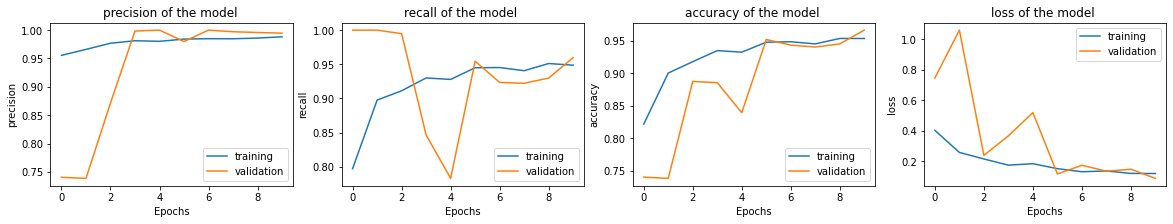

In [64]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for pos, val in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[pos].plot(history.history[val])
    ax[pos].plot(history.history['val_' + val])
    ax[pos].set_title('{} of the model '.format(val))
    ax[pos].set_xlabel('Epochs')
    ax[pos].set_ylabel(val)
    ax[pos].legend(['training', 'validation'])

In [65]:
model.evaluate(data_test)

39/39 [==============================] - 14s 362ms/step - loss: 0.5947 - accuracy: 0.8125 - precision: 0.7735 - recall: 0.9897


## Improving Model Performance

In [66]:
cp = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",save_best_only=True)

stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [67]:
def ExpLR(lr_start, s):
    def ExpLRB(epoch):
        return lr_start * 0.1 **(epoch / s)
    return ExpLRB

ExpLRB = ExpLR(0.01, 20)

rate_fix = tf.keras.callbacks.LearningRateScheduler(ExpLRB)

In [73]:
history = model.fit(
    data_train,
    steps_per_epoch=tf.data.experimental.cardinality(collect_train_complete).numpy() // (16 * stratcr.num_replicas_in_sync),
    epochs=10,
    validation_data=data_val,
    validation_steps=tf.data.experimental.cardinality(collect_val_complete).numpy() // (16 * stratcr.num_replicas_in_sync),
    class_weight=class_weight,
    callbacks=[cp, stop, rate_fix]
)


Epoch 1/10
261/261 [==============================] - 210s 805ms/step - loss: 0.1912 - accuracy: 0.9265 - precision: 0.9784 - recall: 0.9214 - val_loss: 0.1686 - val_accuracy: 0.9577 - val_precision: 0.9617 - val_recall: 0.9818 - lr: 0.0100
Epoch 2/10
261/261 [==============================] - 210s 804ms/step - loss: 0.2004 - accuracy: 0.9291 - precision: 0.9778 - recall: 0.9255 - val_loss: 0.0952 - val_accuracy: 0.9654 - val_precision: 0.9817 - val_recall: 0.9715 - lr: 0.0089
Epoch 3/10
261/261 [==============================] - 212s 813ms/step - loss: 0.1573 - accuracy: 0.9444 - precision: 0.9851 - recall: 0.9394 - val_loss: 0.4413 - val_accuracy: 0.8423 - val_precision: 1.0000 - val_recall: 0.7862 - lr: 0.0079
Epoch 4/10
261/261 [==============================] - 212s 812ms/step - loss: 0.1450 - accuracy: 0.9500 - precision: 0.9879 - recall: 0.9443 - val_loss: 0.1210 - val_accuracy: 0.9538 - val_precision: 0.9905 - val_recall: 0.9466 - lr: 0.0071
Epoch 5/10
261/261 [================

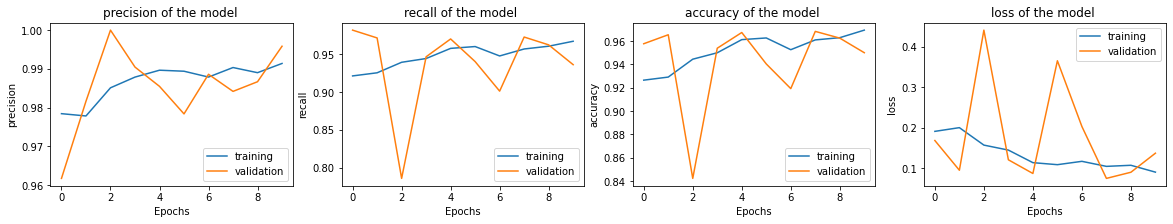

In [75]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for pos, val in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[pos].plot(history.history[val])
    ax[pos].plot(history.history['val_' + val])
    ax[pos].set_title('{} of the model '.format(val))
    ax[pos].set_xlabel('Epochs')
    ax[pos].set_ylabel(val)
    ax[pos].legend(['training', 'validation'])

In [76]:
 model.evaluate(data_test)

39/39 [==============================] - 14s 362ms/step - loss: 0.3927 - accuracy: 0.8734 - precision: 0.8510 - recall: 0.9667


In [68]:
history = model.fit(
    data_train,
    steps_per_epoch=tf.data.experimental.cardinality(collect_train_complete).numpy() // (16 * stratcr.num_replicas_in_sync),
    epochs=25,
    validation_data=data_val,
    validation_steps=tf.data.experimental.cardinality(collect_val_complete).numpy() // (16 * stratcr.num_replicas_in_sync),
    class_weight=class_weight,
    callbacks=[cp, stop, rate_fix]
) 

Epoch 1/25
261/261 [==============================] - 212s 813ms/step - loss: 0.4590 - accuracy: 0.7871 - precision: 0.9175 - recall: 0.7841 - val_loss: 0.4141 - val_accuracy: 0.8365 - val_precision: 0.9886 - val_recall: 0.7880 - lr: 0.0100
Epoch 2/25
261/261 [==============================] - 222s 849ms/step - loss: 0.3061 - accuracy: 0.8728 - precision: 0.9612 - recall: 0.8635 - val_loss: 0.2217 - val_accuracy: 0.9144 - val_precision: 0.9461 - val_recall: 0.9374 - lr: 0.0089
Epoch 3/25
261/261 [==============================] - 229s 875ms/step - loss: 0.2611 - accuracy: 0.8906 - precision: 0.9655 - recall: 0.8841 - val_loss: 0.1589 - val_accuracy: 0.9356 - val_precision: 0.9795 - val_recall: 0.9322 - lr: 0.0079
Epoch 4/25
261/261 [==============================] - 212s 812ms/step - loss: 0.2164 - accuracy: 0.9157 - precision: 0.9751 - recall: 0.9098 - val_loss: 0.2268 - val_accuracy: 0.9096 - val_precision: 0.9913 - val_recall: 0.8856 - lr: 0.0071
Epoch 5/25
261/261 [================

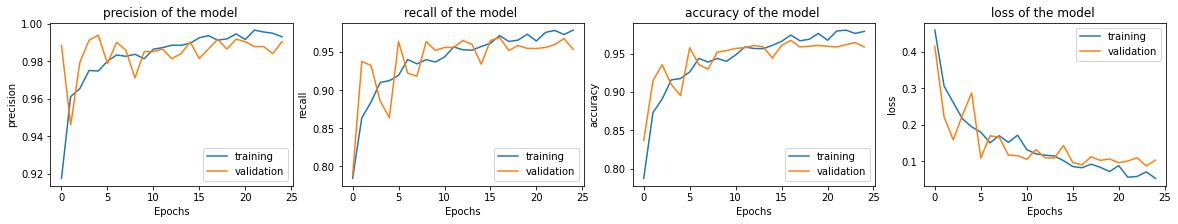

In [70]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for pos, val in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[pos].plot(history.history[val])
    ax[pos].plot(history.history['val_' + val])
    ax[pos].set_title('{} of the model '.format(val))
    ax[pos].set_xlabel('Epochs')
    ax[pos].set_ylabel(val)
    ax[pos].legend(['training', 'validation'])

In [72]:
 model.evaluate(data_test)

39/39 [==============================] - 14s 362ms/step - loss: 0.9176 - accuracy: 0.7997 - precision: 0.7655 - recall: 0.9795
